# Fraud Detection

Author: Madeline Chu

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. Yes

https://www.kaggle.com/datasets/aryan208/financial-transactions-dataset-for-fraud-detection/data 

### Imports

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from IPython.display import display
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Stratified Sample
The original data contained 5 million samples of financial transactions. I will be using a sample size of 5000.

I am stratifying the data by whether the activity is fraud or not, this will ensure that I have enough cases of financial fraud so I can analyze the relationship between the fraud and features.

In [6]:
# This is all code that I used to stratify the sample.

# Load the data set
df = pd.read_csv('/Users/madelinechu/Downloads/financial_fraud_detection_dataset.csv')

#change the NaN values from fraudtype to 'Not Fraud' so they don't get dropped
df['fraud_type'] = df['fraud_type'].fillna('Not Fraud')

#cleaning and reindexing so I can create a stratified sample
df_clean = df.dropna()
df_clean = df_clean.reset_index(drop=True)

#create an index for the column
target_col = 'is_fraud'

# Stratified sampling, these lines are from Chatgpt.
splitter = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=8)

for _, sample_index in splitter.split(df_clean, df_clean[target_col]):
    stratified_sample = df_clean.loc[sample_index]

In [7]:
# Use 3000 of the collected data
stratified_sample.to_csv('/Users/madelinechu/Downloads/stratified_fraud_sample_5000.csv', index=False)

# Show sample
stratified_sample.head()

transaction_id                   timestamp sender_account  \
2185037       T3154711  2023-03-30T07:15:17.369205      ACC247896   
2482596       T3461026  2023-10-02T00:28:00.955486      ACC460461   
181111         T737613  2023-10-10T18:10:04.452613      ACC169410   
3571094       T4564845  2023-09-22T20:53:07.315571      ACC492144   
972296        T1842120  2023-04-30T08:12:58.062014      ACC339542   

        receiver_account  amount transaction_type merchant_category location  \
2185037        ACC799578  224.51       withdrawal         utilities    Dubai   
2482596        ACC454022   16.83          payment           grocery   Berlin   
181111         ACC432109   89.04          payment             other  Toronto   
3571094        ACC410595    4.12         transfer           grocery    Dubai   
972296         ACC130395  393.32       withdrawal            travel   Sydney   

        device_used  is_fraud        fraud_type  time_since_last_transaction  \
2185037      mobile     False         Not Fraud                 -3339.180043   
2482596      mobile     False         Not Fraud                  2234.889287   
181111          web     False         Not Fraud                  -794.250890   
3571094         web      True  card_not_present                  3705.568076   
972296       mobile     False         Not Fraud                 -4001.069331   

         spending_deviation_score  velocity_score  geo_anomaly_score  \
2185037                      0.79               8               0.49   
2482596                      0.80              18               0.06   
181111                      -0.36               8               0.32   
3571094                      0.28              11               0.18   
972296                       1.89              15               0.03   

        payment_channel       ip_address device_hash  
2185037            card   188.113.95.154    D2057361  
2482596            card     203.60.84.46    D4574144  
181111             card    152.29.53.109    D6762473  
3571094             ACH  230.161.113.129    D8221144  
972296              ACH    13.91.200.205    D9433689

## Features
**Transaction ID** - ID number for each transaction.
<br>

**Timestamp** - Time which the transaction took place. In ISO format.
<br>

**Sender Account** - Account number of the sender.
<br>

**Receiver Account** - Account number of the receiver.
<br>

**Amount** - Amount involved in the transaction.
<br>

**Transaction Type** - Type of transaction: deposit, withdrawal, transfer, or payment.
<br>

**Merchant Category** - Type of business the payment was involved in. (retail, traveling, etc.)
<br>

**Location** - City the transaction happened.
<br>

**Device Used** - Type of device. (mobile, POS, ATM, etc.)
<br>

**Is it Fraud?** - Was it fraud, in booleans.
<br>

**Fraud Type** - Type of fraud. (Hacker, money laundering, account takeover, etc.)
<br>

**Time Since Last Transaction** - Time in hours between transactions.
<br>

**Spending Deviation Score** - Deviation from a gaussian distribution.
<br>

**Velocity Score** - Not the time but how many transactions made in a short period of time.
<br>

**Geo Anomaly Score** - Measure of how unusual the transaction was.
<br>

**Payment Channel** - Channel used: card, wire transfer, etc.
<br>

**IP Address** - IP addresses of the transaction.
<br>

**Device Hash** - A unique way of identification on a device.
<br>




## Data Cleaning

I will start by taking all my categorical data and turning it into numerical data. After doing some research, I was choosing between one-hot encode or target encoding however I ultimately wanted to the number of columns to a minimum so I will be applying the target encode method to my dataset.

In [11]:
#the indices of the columns that are categorical
encode_cols = ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel']

#Changing the date time format and only taking out the hour of the day the transaction was made. 
#The decision was that I felt like hour of the day would most likely hold the most information with regards to being fraud/not-fraud.
stratified_sample['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601', utc=True) #code fixed by chatgpt
stratified_sample['hour'] = stratified_sample['timestamp'].dt.hour

#splitting the data, (df is used but it is on the stratified sample)
train_df, test_df = train_test_split(stratified_sample, test_size=0.2, stratify=stratified_sample['is_fraud'], random_state=8)

stratified_sample.head()

transaction_id                        timestamp sender_account  \
2185037       T3154711 2023-12-11 23:53:08.903327+00:00      ACC247896   
2482596       T3461026 2023-05-06 00:23:18.546703+00:00      ACC460461   
181111         T737613 2023-03-29 01:48:24.296081+00:00      ACC169410   
3571094       T4564845 2023-11-28 09:11:16.099287+00:00      ACC492144   
972296        T1842120 2023-04-05 05:37:45.332087+00:00      ACC339542   

        receiver_account  amount transaction_type merchant_category location  \
2185037        ACC799578  224.51       withdrawal         utilities    Dubai   
2482596        ACC454022   16.83          payment           grocery   Berlin   
181111         ACC432109   89.04          payment             other  Toronto   
3571094        ACC410595    4.12         transfer           grocery    Dubai   
972296         ACC130395  393.32       withdrawal            travel   Sydney   

        device_used  is_fraud        fraud_type  time_since_last_transaction  \
2185037      mobile     False         Not Fraud                 -3339.180043   
2482596      mobile     False         Not Fraud                  2234.889287   
181111          web     False         Not Fraud                  -794.250890   
3571094         web      True  card_not_present                  3705.568076   
972296       mobile     False         Not Fraud                 -4001.069331   

         spending_deviation_score  velocity_score  geo_anomaly_score  \
2185037                      0.79               8               0.49   
2482596                      0.80              18               0.06   
181111                      -0.36               8               0.32   
3571094                      0.28              11               0.18   
972296                       1.89              15               0.03   

        payment_channel       ip_address device_hash  hour  
2185037            card   188.113.95.154    D2057361    23  
2482596            card     203.60.84.46    D4574144     0  
181111             card    152.29.53.109    D6762473     1  
3571094             ACH  230.161.113.129    D8221144     9  
972296              ACH    13.91.200.205    D9433689     5

                        amount  velocity_score  geo_anomaly_score  \
amount                1.000000       -0.024284           0.002632   
velocity_score       -0.024284        1.000000          -0.006721   
geo_anomaly_score     0.002632       -0.006721           1.000000   
transaction_type_TE   0.512677       -0.033048           0.008495   
merchant_category_TE  0.005506       -0.025558           0.011403   
location_TE          -0.007487       -0.003133           0.009528   
device_used_TE        0.043387        0.003006           0.001229   
payment_channel_TE    0.028426        0.005446           0.011014   
hour                  0.027196        0.004868          -0.019790   
is_fraud              0.009866       -0.003198           0.003820   

                      transaction_type_TE  merchant_category_TE  location_TE  \
amount                           0.512677              0.005506    -0.007487   
velocity_score                  -0.033048             -0.025558    -0.003133   


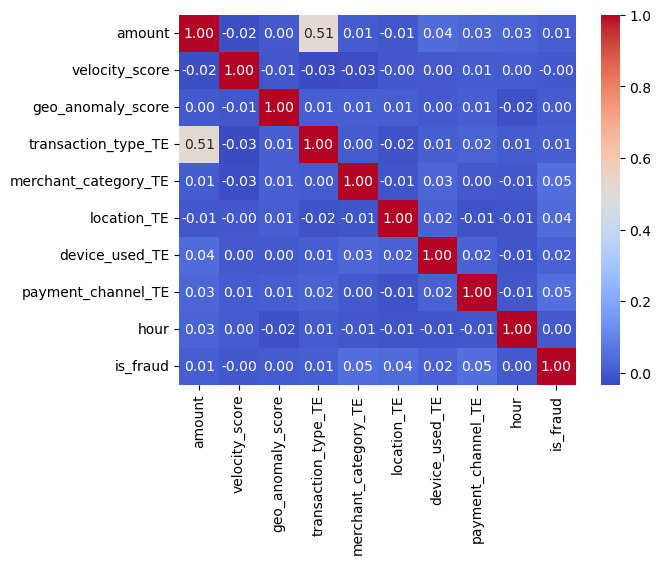

In [12]:

#target column name and list of column indices
target_col = 'is_fraud'
feature_cols = ['amount',
                'velocity_score',
                'geo_anomaly_score',
                'transaction_type_TE',
                'merchant_category_TE',
                'location_TE',
                'device_used_TE',
                'payment_channel_TE',
               'hour']

#target mean for all columns
for col in encode_cols:
    target_means = train_df.groupby(col)[target_col].mean() # command from chatgpt
    train_df[f'{col}' + '_TE'] = train_df[col].map(target_means) # command from chatgpt
    test_df[f'{col}' + '_TE'] = test_df[col].map(target_means) # command from chatgpt


corr = train_df[feature_cols + [target_col]].corr()
train_df.head()

#correlation matrix, code taken from Professor Ray's website
corr = train_df[feature_cols + ['is_fraud']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt = ".2f")
print(corr)

We can see that whether a case is constituted as fraudulent does not have a strong correlation with any of the features. However, this makes sense as a lot of the features take note of the instance of transaction and what device, amount or other characteristics these transactions have. If you think about the real world we would not expect that one characteristic of a transaction would affect very highly whether it is fraud or not. 

## Addressing the minority class
In a data set like this, the number of fraudulent cases is expected to be a lot lower just because most financial transactions are not fraudulent. From a suggestion by chatgpt, I began to research SMOTE. SMOTE is advantageous because it creates more instances of the minority cases of the target feature. It is an interesting method as it takes from the concept of **k-nearest neighbors** in interpolating between the existing cases of fraud to create new cases of fraud.

*code was learned from: https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/*

In [15]:
#all feature columns
feature_cols = ['amount',
                'velocity_score',
                'geo_anomaly_score',
                'transaction_type_TE',
                'merchant_category_TE',
                'location_TE',
                'device_used_TE',
                'payment_channel_TE',
               'hour']
#applying smote 
smote = SMOTE(random_state=8)

# separated the features from the target.
X_train = train_df[feature_cols]
y_train = train_df['is_fraud']

#resampling with SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Separating my testing sets
X_test = test_df[feature_cols] 
y_test = test_df['is_fraud']

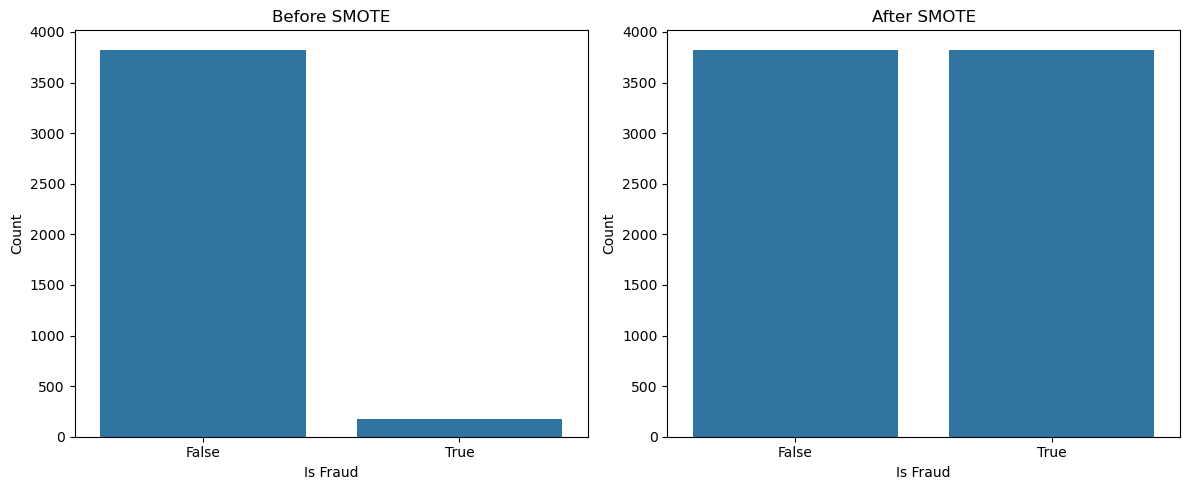

In [16]:
# Plotting before and after smote results

#converting the training set to a panda series. 
y_train_df = y_train_resampled.to_frame()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x = 'is_fraud', data = train_df, ax=axes[0])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Is Fraud')
axes[0].set_ylabel('Count')

sns.countplot(x = 'is_fraud', data = y_train_df, ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Is Fraud')
axes[1].set_ylabel('Count')
plt.tight_layout()


## Logistic Regression
Now I perform Logistic Regression by fitting on the training set and then predicting the train set. The logistic regression is fit with the SMOTE resampled set. Keep in mind that my my training and testing set only have features that I deem as important. For example, I did not include the columns that contained IP address, identification of case, etc.

Text(50.722222222222214, 0.5, 'Actual Label')

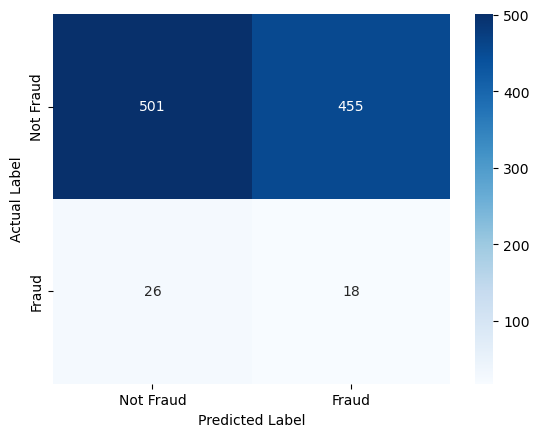

In [18]:
model = LogisticRegression(max_iter=1000) # max_iter from chat gpt
# fitting the logistic regression
model.fit(X_train_resampled, y_train_resampled)

# predicting the amount of fraud from the testing set
Y_pred = model.predict(X_test)
Y_pred_series = pd.Series(Y_pred)

#resetting the index for the testing and predicted values.
Y_actual_new_idx = test_df['is_fraud'].reset_index(drop=True)
Y_pred_series = pd.Series(Y_pred).reset_index(drop=True)

#dataframe for compare test
df_compare_test = pd.DataFrame({ 'Actual' : Y_actual_new_idx, 'Predicted' : Y_pred_series})

#plotting a confusion matrix
confusion_mtrx = confusion_matrix(df_compare_test['Actual'], df_compare_test['Predicted'])
sns.heatmap(confusion_mtrx, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

It seems like a basic logistic regression did not accurately classify non-fraudulent cases. This make sense because logistic regression assumes a linear decision boundary, or in this case, a multidimensional plane. This then further assumes that theres a big distinction between fraudulent and non-fraudulent cases. However, this is not likely because it is very possible that the fraudulent case will be very similar to a non-fraudulent case.

## Now we can try K nearest neighbors.
We want to start by finding the optimal K.

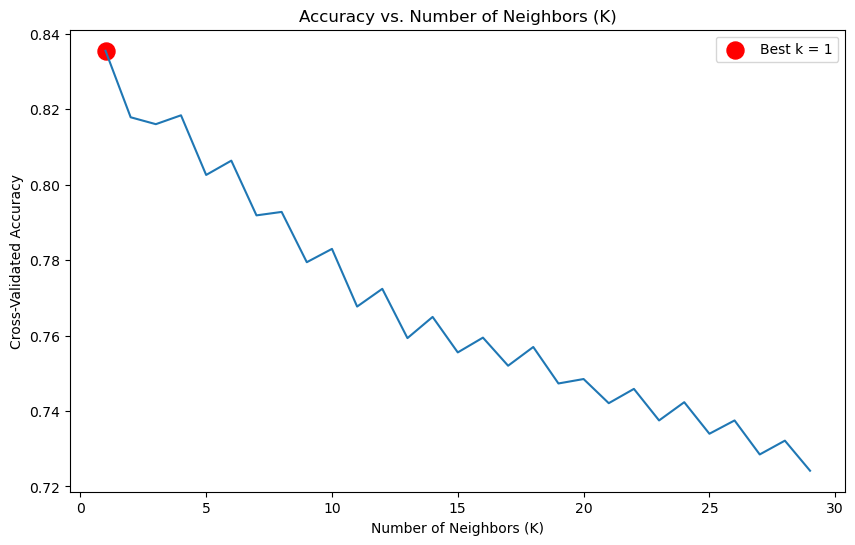

Best k value: 1
Best Cross-Val-Score: 0.8356
Accuracy: 0.744
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.76      0.85       956
        True       0.05      0.30      0.09        44

    accuracy                           0.74      1000
   macro avg       0.51      0.53      0.47      1000
weighted avg       0.92      0.74      0.82      1000



In [21]:
#testing from 1 nn to 30.
k_range = range(1, 30)

#comparing the score for each value of k neighbors.
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
#Plotting the accuracy of each k vs. the number I chose for k
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.title('Accuracy vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')

best_k = k_range[np.argmax(k_scores)]
best_score = max(k_scores)

plt.scatter(best_k, best_score, color='red', s=150, label=f'Best k = {best_k}')
plt.legend()

plt.show()

print(f'Best k value: {best_k}')
print(f'Best Cross-Val-Score: {best_score:.4f}')

model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_train_resampled, y_train_resampled)
y_pred_knn = model_knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_knn)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_knn, zero_division=0)) # code from chatgpt

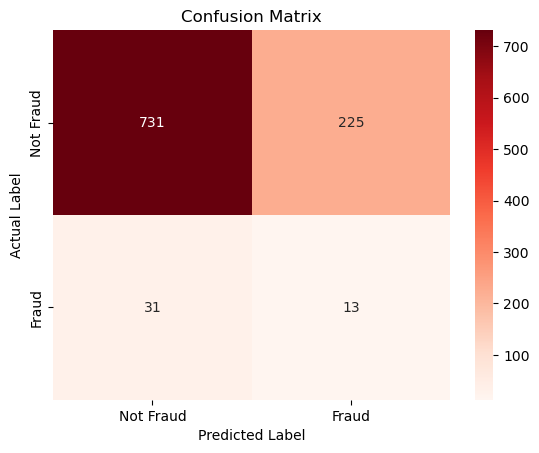

In [22]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

As we can see, the KNN method seems better at classifying cases than the logistic regression. For example, previously it predicted that 455 of the non-fraud cases were fraudulent however with the choice of 1 nearest neighbor, it classified only 225 non-fraudulent cases incorrectly. So we are seeing that in the case of fraud detection K-nearest neighbors seem more effective, this makes sense because rather than seeing a clear relationship between fraud cases, we are looking at data points that are close to each other.

### Visualization of each feature and the target value.
Now, I am interested in finding if there is a specifice feature that is prominent in all of these fraud cases. We will do this by looking at the Random forest importance graph.

Code adopted from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Code fixed by chatgpt.

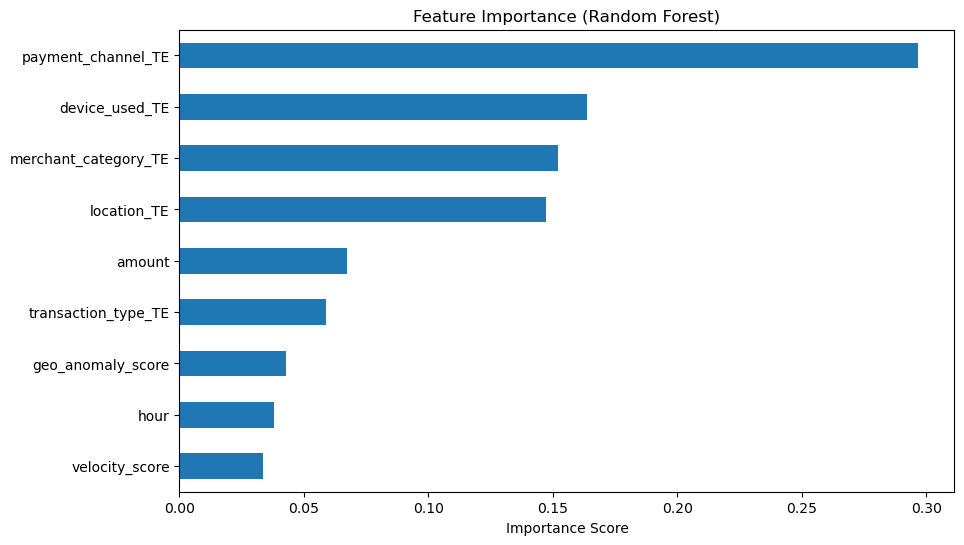

In [25]:

# Train model
rf_model = RandomForestClassifier(random_state=8)
rf_model.fit(X_train_resampled, y_train_resampled)

# Plot feature importances
importances = rf_model.feature_importances_
feature_names = X_train_resampled.columns

# Create bar plot
plt.figure(figsize=(10, 6))
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.show()


Note that payment_channel_TE has the highest importance value out of all our features. But the importance score is around 0.29, however that is not large compared to an importance value of 1. 

## Interpreting the decision tree.
On the decision tree, the value is given in the form **[non-fraud case, fraud case]**.
<br>
Code from: https://scikit-learn.org/stable/modules/tree.html
<br>
Learned from: https://www.geeksforgeeks.org/decision-tree-implementation-python/

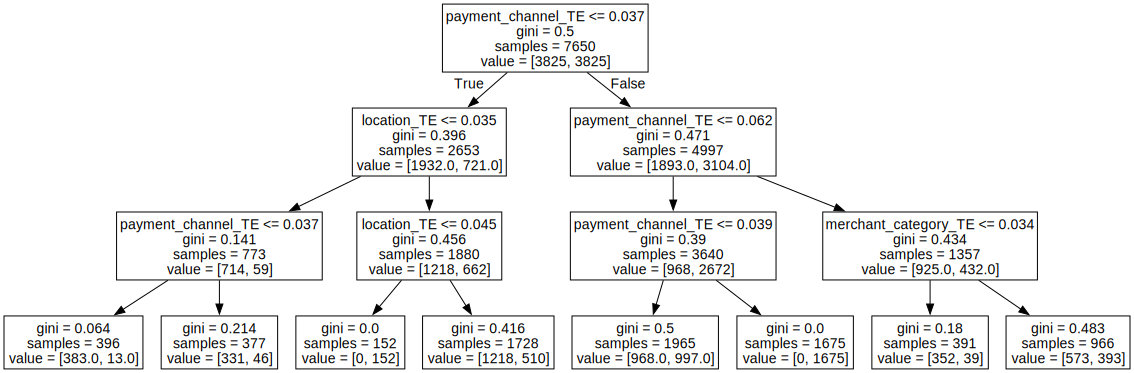

In [28]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz


# Create a decision tree classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)


# Fit the classifier on the dataset
clf.fit(X_train_resampled, y_train_resampled)

# Extract decision tree information
dot_data = export_graphviz(clf, out_file=None, feature_names=feature_cols)

# Create a graph object and render
graph = graphviz.Source(dot_data)
display(graph)

If you look at the final classification, and look at the second branch node to the right, it correctly determined that if the data's payment_channel_TE value is  $0.039 \leq x \leq 0.062$. Then these cases will be fraud cases. So we can take a look at the relation of the payment channel with whether the case is fraud or not.

In [30]:
#We are looking at the rows that have this feature, but more specifically, the transaction type that corresponds to the value.
train_df.loc[(train_df['payment_channel_TE']>=0.039) & (train_df['payment_channel_TE']<=0.062)].head(3)

transaction_id                        timestamp sender_account  \
2519793       T3499115 2023-07-06 02:00:02.246527+00:00      ACC536513   
3405053       T4397515 2023-09-06 08:33:07.867799+00:00      ACC598679   
740399        T1563167 2023-04-16 05:22:52.174555+00:00      ACC804679   

        receiver_account   amount transaction_type merchant_category  \
2519793        ACC597424    46.06         transfer         utilities   
3405053        ACC663765    16.46         transfer     entertainment   
740399         ACC412353  1274.26          deposit            online   

         location device_used  is_fraud  ... geo_anomaly_score  \
2519793    London         web     False  ...              0.62   
3405053  New York         pos     False  ...              0.69   
740399    Toronto         pos     False  ...              0.16   

         payment_channel       ip_address  device_hash  hour  \
2519793              UPI     31.16.229.76     D4775399     2   
3405053              UPI   100.127.10.209     D8857882     8   
740399               UPI  138.129.139.178     D5495797     5   

        transaction_type_TE merchant_category_TE location_TE  device_used_TE  \
2519793            0.044834             0.033272    0.045455        0.040415   
3405053            0.044834             0.047170    0.053030        0.045498   
740399             0.046701             0.063877    0.035225        0.045498   

         payment_channel_TE  
2519793            0.061866  
3405053            0.061866  
740399             0.061866  

[3 rows x 24 columns]

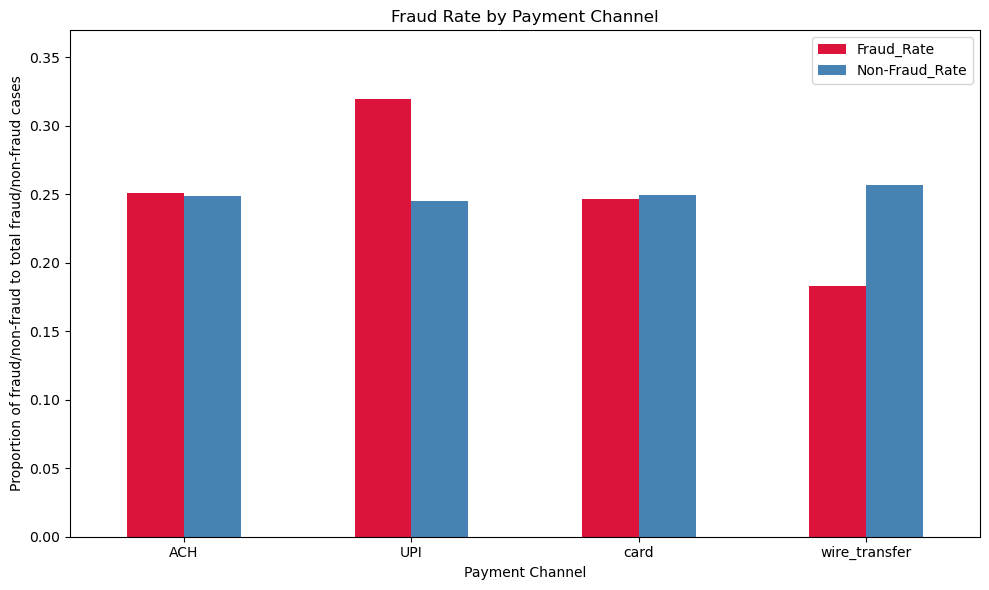

In [31]:
#We want to count how many fraud cases there are per payment channel
fraud_count = stratified_sample[stratified_sample['is_fraud']==1].groupby('payment_channel').size()
nonfraud_count = stratified_sample[stratified_sample['is_fraud']==0].groupby('payment_channel').size()

#Then we find how many fraud cases there are vs. non-fraud cases
total_counts_fraud = stratified_sample.groupby('is_fraud').size()

#divide the fraud case per payment channel by total fraud case
fraud_rate = fraud_count/total_counts_fraud.iloc[1]

#divide the non-fraud case per payment channel by total non-fraud case
nonfraud_rate = nonfraud_count/total_counts_fraud.iloc[0]

#turn these values into a dataframe so they are easily plotted
rate_df = pd.DataFrame({'Fraud_Rate':fraud_rate,
                        'Non-Fraud_Rate': nonfraud_rate})

#plot the proportions nect to each other.
rate_df.plot(kind='bar', color=['crimson', 'steelblue'], figsize=(10,6))
plt.title('Fraud Rate by Payment Channel')
plt.xlabel('Payment Channel')
plt.ylabel('Proportion of fraud/non-fraud to total fraud/non-fraud cases')
plt.xticks(rotation=0)
plt.ylim(0, fraud_rate.max()+.05) 
plt.tight_layout()
plt.show()


### Conclusion

In conclusion, although we have narrowed down where a lot of fraudulent cases come from, the relationship between fraud and the features I have included is inconclusive. Because we consider that while for the payment channel 'UPI', while a lot of the fraud cases corresponded to this payment channel, there is still many cases of non-fraud that makes mayment through UPI. So ultimately the data is inconclusive.